## 1. Setup and Load Data

### 1.1 Install Dependencies and Setup

In [1]:
#%pip install tensorflow opencv-python matplotlib #tensorflow - data planning pipeline, opencv - remove dodgy imgs, matplotlib -  visualize imgs

In [2]:
#%pip list

In [3]:
import tensorflow as tf
import os #navigate file structure
#os.path.join('data', 'happy') # -returns the folder structure
#os.listdir('data') #- list everythinng inside this folder

### 1.2 Remove dodgy images

In [4]:
import cv2 
import imghdr #check file exts

/var/folders/r8/17pq6sn558jfc7m45jly_l2r0000gn/T/ipykernel_18615/1947259512.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr #check file exts


In [5]:
data_dir = 'data' #var to hold path to our data dir

In [6]:
image_exts = ['jpg', 'jpeg', 'png', 'bmp'] 

In [7]:
image_exts[2]
os.listdir(data_dir) # retyrns folders inside the data dir
#os.listdir(os.path.join(data_dir, 'happy')) # loop thru every single img

['happy', 'sad']

In [8]:
for image_class in os.listdir(data_dir): #loop thru every folder in our data dir
    for image in os.listdir(os.path.join(data_dir, image_class)): #every single folder inside the data dir ie (data;happy) and (data;sad)
        image_path = os.path.join(data_dir, image_class, image) #every single img - data-happy-imgs/ data-sad-imgs
        try: 
            img = cv2.imread(image_path) #check we can load img into opencv
            tip = imghdr.what(image_path) #check it matches the exts
            if tip not in image_exts:
                print('image not in ext list {}'.format(image_path))
                os.remove(image_path) #rempve if its weird 

        except Exception as e:
            print('issue with image {}'.format(image_path))
            #os.remove(image_path)

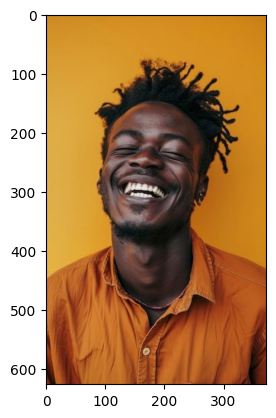

In [9]:
from matplotlib import pyplot as plt
img = cv2.imread(os.path.join('data', 'happy', '0f2fc2d2e47c2e17fce6ad0849681825.jpg'))
img
img.shape
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) #color conversion code
plt.show()

### 1.3 Load Data

In [10]:
#tensorflow has a dataset API - allows to build data piplelines rather than loading everything into memory, which gives you a repeatable set of steps to apply to our data 
#tf.data.Dataset?? #documentation

In [11]:
import numpy as np
from matplotlib import pyplot as plt

In [12]:
#tf.keras.utils.image_dataset_from_directory??

In [13]:
data = tf.keras.utils.image_dataset_from_directory('data') #allows us to pull in our img data from our data folder - builds an img dataset for you
      #building our data pipeline

Found 131 files belonging to 2 classes.


In [14]:
data_iterator = data.as_numpy_iterator() # allow us to access generator from our data pipeline...
     #allowing us to access our data pipeline ie loop thru the data pipleine

In [15]:
#get another batch from the iterator

batch = data_iterator.next() #accessing the data pipeline itself ie grab one batch back

In [16]:
len(batch)  #1.imgs (imgs from our dir loaded into memory as a set of numpy arrays) 2.labels

2

In [17]:
#1. images represented as numpy arrays
batch[0].shape #automaticaly reshapes to ensure they're of the same size


#if you wanted a diff size img
#data = tf.keras.utils.image_dataset_from_directory('data', batch_size=8, image_size=(128,128)) #- however you sih your data set to look like

(32, 256, 256, 3)

In [18]:
#2. label representation
batch[1] #labels: class 1 = sad ppl class 0 = happy ppl

array([0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0], dtype=int32)

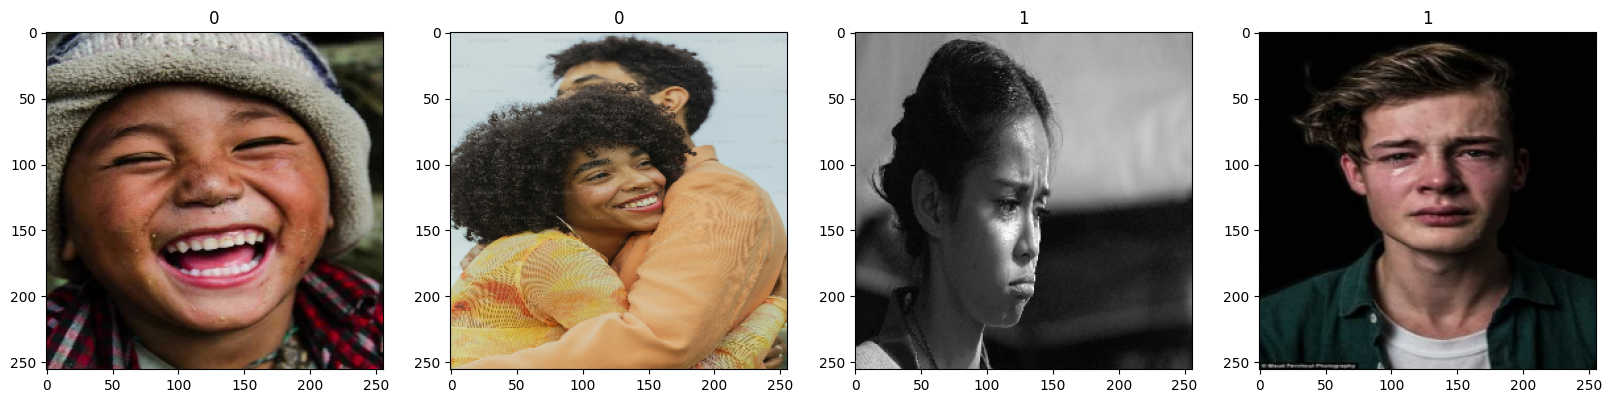

In [19]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## 2. Preprocess data

### 2.1 Scale data

In [20]:
#scaling imgs btwn 0 and 1 rather than 0 to 255 ; 
batch[0].shape
batch[0].max() #-initially gives 0
batch[0].max() #-initially gives 255

np.float32(255.0)

In [21]:
data = data.map(lambda x,y: (x/255, y)) #divide by 255 to scale ... to scale one batch: batch[0] / 255
         #but because we are using a data pipeline, we dont want to scale every single time we load in new batch
         # we wanna do it as we load in the data in the pipeline using the data capabilities
         #data.map allows us to apply to perfomr this scaling transformation in the pipleine itself ie across the dataset
         # x - imgs/255, no transformation on y;labels

In [22]:
data.as_numpy_iterator().next()[1].max()

np.int32(1)

In [23]:
scaled_iterator = data.as_numpy_iterator()

In [24]:
batch = scaled_iterator.next()

In [25]:
batch[0].max()

np.float32(1.0)

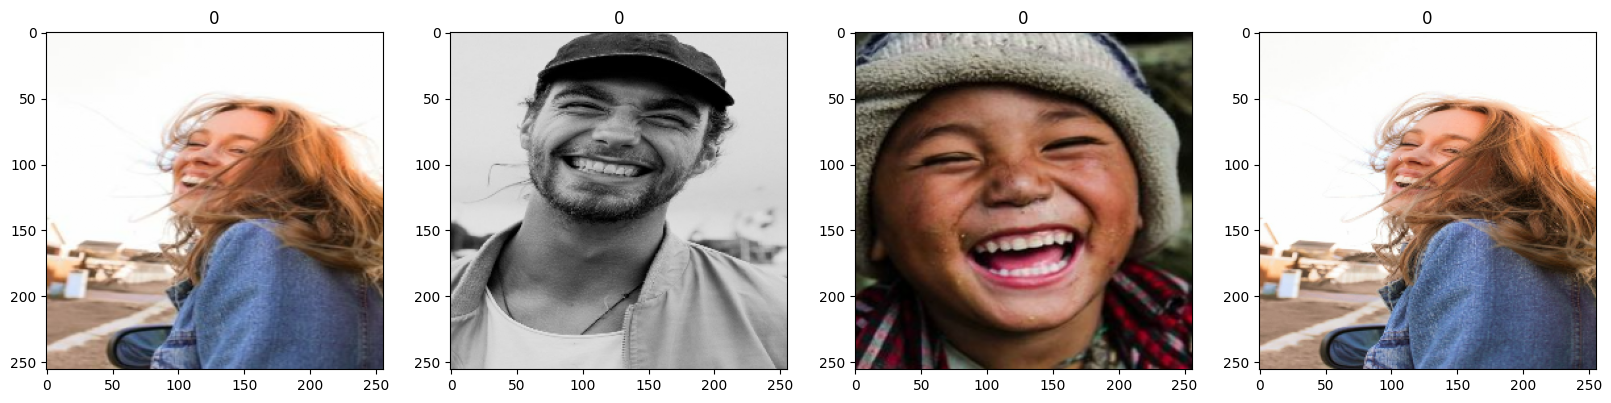

In [26]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img) #we remove astype(int) because at this point we have scaled our data and it is betwen 0 and 1 not 0 and 255
    ax[idx].title.set_text(batch[1][idx])

### 2.2 Split data

In [27]:
#now we split our data into a training and testing partition
len(data) #what is our training data size? - 5 batches, each has 32 imgs

5

In [28]:
train_size = int(len(data)*.7) #70% of data
val_size = int(len(data)*.2) #20% of data
test_size = int(len(data)*.1)+1 #10% of data

In [29]:
train_size #3 * 32 - what is actually used to train our deep leaarning model - pre
val_size #1 * 32 - what is actually used to evaluate our deep learning model while were training -pre
test_size #1 - hold this all the way this the end - post 
train_size + val_size + test_size

5

In [30]:
#using the take and skip methods inside of tensorflow datapipleine
#take - how much data we will take in in that particular partition
#you need to shuffle your data
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size).skip(val_size).take(test_size)

In [31]:
len(test)

1

## 3. Deep model

### 3.1 Build deep learning model

In [32]:
#build a deep learning model using the keras sequential API

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [34]:
model = Sequential()

In [35]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/Users/valaryanguzuzu/Desktop/MLProject/imageClassification/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 3.2 Train

### 3.3 Plot performance

In [36]:
!which python


/Users/valaryanguzuzu/Desktop/MLProject/imageClassification/bin/python
